In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
from glob import glob
from collections import Counter
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

ZIP_PATH = "/content/drive/MyDrive/animal_dataset.zip"
EXTRACT_DIR = "/content/animal_dataset"

if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(ZIP_PATH,'r') as z:
        z.extractall(EXTRACT_DIR)
    print(f"Dataset unzipped to {EXTRACT_DIR}")
else:
    print(f"Dataset already extracted to {EXTRACT_DIR}")

Dataset unzipped to /content/animal_dataset


The dataset is loaded by writing a function that reads images from each class folder (cat, dog, panda). Each image was converted to grayscale, resized to 32×32, normalized to values between 0 and 1, and flattened into a vector. The processed data was stored in X and the class labels in y, preparing the dataset for training the KNN model.


In [ ]:
def load_images_from_folder(folder_path, img_size=(32, 32)):
    X = []
    y = []
    class_names = sorted(os.listdir(folder_path))

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            try:
                img = Image.open(img_path).convert('L')
                img = img.resize(img_size)
                img_array = np.array(img).flatten() / 255.0

                X.append(img_array)
                y.append(class_name)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(X), np.array(y)

DATASET_DIR = os.path.join(EXTRACT_DIR, "animal_dataset")

X, y = load_images_from_folder(DATASET_DIR)

print("Image data shape:", X.shape)
print("Classes:", np.unique(y))



Image data shape: (300, 1024)
Classes: ['cat' 'dog' 'panda']


Implemented two distance functions to use in my KNN classifier. The Manhattan distance (L1) calculates the sum of absolute differences between two vectors, while the Euclidean distance (L2) computes the straight‑line distance using squared differences and a square root.



In [ ]:

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


For each test sample, the function calculates its distance to all training samples using either Manhattan (L1) or Euclidean (L2) distance. It then sorts the training samples by distance, selects the closest k neighbors, and uses majority voting to decide the predicted class. The most common label among the neighbors is returned as the final prediction


In [ ]:
def knn_predict(X_train, y_train, x_test, k, distance_metric):
    distances = []
    for i in range(len(X_train)):
        if distance_metric == 'L1':
            dist = manhattan_distance(X_train[i], x_test)
        else:
            dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))

    distances.sort(key=lambda x: x[0])
    neighbors = [label for (_, label) in distances[:k]]
    most_common = Counter(neighbors).most_common(1)[0][0]
    return most_common


Implemented a cross‑validation procedure to evaluate KNN classifier. The dataset is first shuffled with a fixed random seed for reproducibility, then divided into folds (default 5). For each value of k, the function repeatedly splits the data into training and validation sets: one fold is used for validation while the remaining folds are used for training. Predictions are made on the validation set using the chosen distance metric (L1 or L2), and accuracy is calculated. The average accuracy across all folds is stored for each k. This ensures a fair estimate of model performance and helps identify the best k value.


In [ ]:
def cross_validate(X, y, k_values, distance_metric, folds=5):
    n = len(X)
    indices = np.arange(n)
    np.random.seed(42)
    np.random.shuffle(indices)

    fold_size = n // folds
    accuracies = []

    for k in k_values:
        fold_acc = []
        for f in range(folds):
            val_idx = indices[f*fold_size:(f+1)*fold_size]
            train_idx = np.setdiff1d(indices, val_idx)

            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            preds = []
            for x in X_val:
                preds.append(knn_predict(X_train, y_train, x, k, distance_metric))

            acc = np.mean(np.array(preds) == y_val)
            fold_acc.append(acc)

        accuracies.append(np.mean(fold_acc))
    return accuracies



Evaluated the KNN classifier using both Manhattan (L1) and Euclidean (L2) distance metrics and defined the range of neighbors from 1 to 20 and ran 5‑fold cross‑validation for each value of k. The results for L1 were stored in results_L1 and the results for L2 in results_L2. This allowed me to compare how the choice of distance metric and the number of neighbors affected the overall accuracy of the model


In [ ]:
k_values = range(1, 21)

results_L1 = cross_validate(X, y, k_values, 'L1', folds=5)
results_L2 = cross_validate(X, y, k_values, 'L2', folds=5)


The graph shows results for both Manhattan (L1) and Euclidean (L2) distance metrics using 5‑fold cross‑validation. Each curve illustrates how accuracy changes as K increases, making it easier to compare the two metrics and identify the best value of K for this dataset.


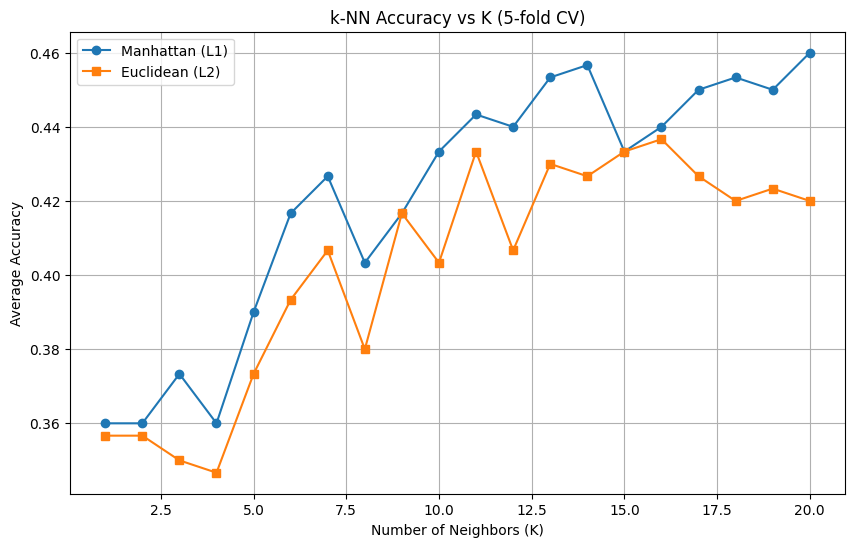

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(k_values, results_L1, marker='o', label='Manhattan (L1)')
plt.plot(k_values, results_L2, marker='s', label='Euclidean (L2)')
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Average Accuracy")
plt.title("k-NN Accuracy vs K (5-fold CV)")
plt.legend()
plt.grid(True)
plt.show()


Identified the best values of K for both Manhattan (L1) and Euclidean (L2) distance metrics by selecting the index of the highest accuracy from the cross‑validation results. The corresponding accuracies and K values were printed to show the optimal settings for each metric. Finally, I compared the two best accuracies and reported which distance metric performed better overall for this dataset.


In [ ]:

best_k_L1 = k_values[np.argmax(results_L1)]
best_acc_L1 = max(results_L1)

best_k_L2 = k_values[np.argmax(results_L2)]
best_acc_L2 = max(results_L2)

print(f"Best Manhattan (L1): K={best_k_L1}, Accuracy={best_acc_L1:.4f}")
print(f"Best Euclidean (L2): K={best_k_L2}, Accuracy={best_acc_L2:.4f}")

if best_acc_L1 > best_acc_L2:
    print("Manhattan (L1) performed better for this dataset.")
else:
    print("Euclidean (L2) performed better for this dataset.")


Best Manhattan (L1): K=20, Accuracy=0.4600
Best Euclidean (L2): K=16, Accuracy=0.4367
Manhattan (L1) performed better for this dataset.


Extended my cross‑validation to compute per‑class accuracy. For each fold, the model predicts labels on the validation set using the best metric and K. Instead of only calculating overall accuracy, the code also measures accuracy separately for each class (cat, dog, panda) by checking how often predictions match the true labels within that class. These per‑class accuracies are averaged across all folds and printed, giving a clearer view of which classes are easier or harder for the KNN classifier to recognize


In [ ]:
from collections import defaultdict

def cross_validate_per_class(X, y, k, distance_metric, folds=5):
    n = len(X)
    indices = np.arange(n)
    np.random.seed(123)
    np.random.shuffle(indices)

    fold_size = n // folds
    class_acc = defaultdict(list)

    for f in range(folds):
        val_idx = indices[f*fold_size:(f+1)*fold_size]
        train_idx = np.setdiff1d(indices, val_idx)

        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        preds = []
        for x in X_val:
            preds.append(knn_predict(X_train, y_train, x, k, distance_metric))
        preds = np.array(preds)


        for cls in np.unique(y):
            cls_idx = np.where(y_val == cls)[0]
            if len(cls_idx) > 0:
                acc = np.mean(preds[cls_idx] == y_val[cls_idx])
                class_acc[cls].append(acc)


    avg_class_acc = {cls: np.mean(accs) for cls, accs in class_acc.items()}
    return avg_class_acc


best_metric = 'L1' if best_acc_L1 > best_acc_L2 else 'L2'
best_k = best_k_L1 if best_acc_L1 > best_acc_L2 else best_k_L2

per_class_results = cross_validate_per_class(X, y, best_k, best_metric, folds=5)

print(f"\nPer-class Accuracy (Cross-Validation, {best_metric}, K={best_k}):")
for cls, acc in per_class_results.items():
    print(f"{cls}: {acc:.4f}")


Per-class Accuracy (Cross-Validation, L1, K=20):
cat: 0.3290
dog: 0.7043
panda: 0.2793


Five random samples from the dataset is displayed to show how the KNN classifier performs with the best metric and K value. A fixed random seed was used to ensure reproducibility when selecting the images. For each sample, the model predicted its label, which was compared against the true label. The images were plotted in grayscale with both the true class (T) and predicted class (P) shown in the title. This visualization provides a clear example of the model’s predictions and highlights where it succeeds or makes mistakes.



Top 5 Predictions:


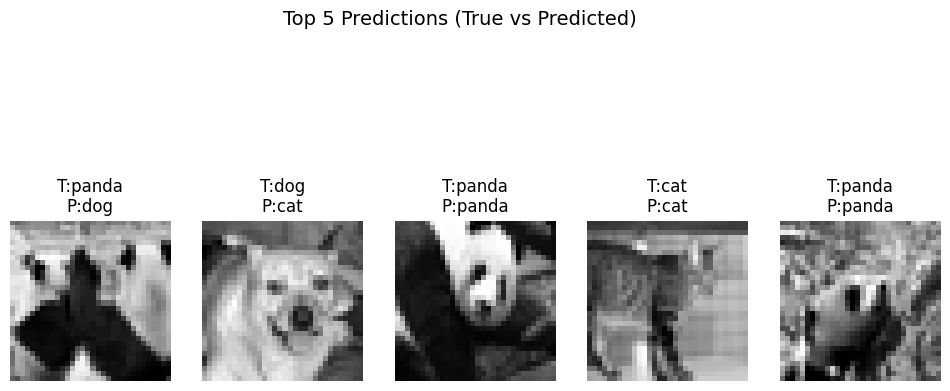

In [ ]:
best_metric = 'L1' if best_acc_L1 > best_acc_L2 else 'L2'
best_k = best_k_L1 if best_acc_L1 > best_acc_L2 else best_k_L2

print("\nTop 5 Predictions:")
np.random.seed(789)
indices = np.random.choice(len(X), 5, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    pred = knn_predict(X, y, X[idx], best_k, best_metric)
    true_label = y[idx]


    plt.subplot(1, 5, i+1)
    plt.imshow(X[idx].reshape(32, 32), cmap='gray')
    plt.title(f"T:{true_label}\nP:{pred}")
    plt.axis('off')

plt.suptitle("Top 5 Predictions (True vs Predicted)", fontsize=14)
plt.show()